# **Needed Libraries**


In [1]:
# Data science 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
import pickle
from sklearn.mixture import GaussianMixture
# Single cell 
import scanpy as sc
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 19})
# Output control
import warnings
warnings.filterwarnings("ignore")

# **File Dependancies**


In [2]:
from utils.plotting import  posterior_heatmap, plot_state_cellsums, make_ellipses_joint

We load the example gmm model saved in the last part of the previous stage and our example dataset


In [3]:
filename  = "models/example_gmm.pkl"
with open(filename, "rb") as file:
    example_gmm = pickle.load(file)

adata = sc.read("processed_datasets/dataset3.h5ad")
optimal_pca_component = 2

example_gmm

GaussianMixture(init_params='k-means++', max_iter=500, n_components=2,
                random_state=67)

# **Stage 4: Visualization**


## **Basic attributes of GMMs**


While it was sufficient to plot the GMM components to demonstrate our results in the previous stage. In order to truly understand the results of the GMM models, it is essential to understand their attributes to create a convincing visualization.


A Gaussian mixture model assumes that the data is generated by a mixture of Gaussian components. In the case of multivariate components, after fitting it to the data its probability density function (PDF) is represented by the following equation:
$$P(\vec{x}) = \sum_{i=1}^{k} w_i \cdot \mathcal{N}(\vec{x}| \vec{\mu_i}, \Sigma_i)$$

- $w_i$ represents the weight coefficient of each of the $k$ components that constitute the mixture, we can get this information by callaing `example_gmm.weights_`. As you can see below our example model from the previous stage has a component with a small weight and two other with realtively similar weights. Of course the mixing coefients should sum up to one.


In [4]:
example_gmm.weights_

array([0.33256756, 0.66743244])

- $\vec{\mu_i}$ are the means of each of the distribution components. These can be accessed through `example_gmm.means_`. By examining these means, we can understand the location or position of each component in the representation space.


In [5]:
example_gmm.means_

array([[ 4.16531354,  0.28963972],
       [-2.07548817, -0.1443213 ]])

- $\Sigma_i$ represents the covariance matrix of each component, capturing the spread, shape, and orientation of the Gaussian distribution. This information is available through `example_gmm.covariances_`. In the example model we have **full covariance**, this means that each component of the GMM has its own covariance matrix as shown below. Of course this type of covariance has the most parameters.


In [6]:
example_gmm.covariances_

array([[[ 3.6070355 ,  0.86614822],
        [ 0.86614822,  2.08453063]],

       [[ 6.60033483, -1.33226495],
        [-1.33226495,  1.66470489]]])

other cases in decreasing order of number of parameters are:

- Tied Covariance:
  With tied covariance, all components of the GMM share a single covariance matrix. This assumption implies that all the Gaussian distributions have the same spread, shape, and orientation.

- Diagonal Covariance:
  In this case, each component of the GMM has its own covariance matrix, but the matrices are constrained to be diagonal. This means that the variables are assumed to be independent, and there are no correlations between them within each Gaussian distribution.

- Spherical Covariance:
  Spherical covariance assumes that all components of the GMM have the same isotropic covariance matrix. This implies that the spread is the same along all axes, and there are no correlations or variations in shape and orientation.


## **posterior and joint probabilites**


### _posterior probabilities_


The posterior probabilities of a cell vector $\vec{x}$ being generated by each of the components. This probability is denoted as: $$p(\vec{x}|c_i)$$ , can be obtained using the `example_gmm.predict_proba(X)` function. This function returns a matrix of size (cells, components), where each value in a column represents the p|osterior probability of a cell vector for each of the mixture components.


In [7]:
X = adata.obsm['X_pca'][:,:optimal_pca_component]
posteriors = example_gmm.predict_proba(X)
labels = example_gmm.predict(X)
posteriors.shape

(199, 2)

`make_ellipses` worked well for a showcase of the clsutering stage, but we have upgraded further to `make_ellipses_posteriors` which present a more complete picture including the posterior probabilites.
As you can see below it visualizes a Gaussian Mixture Model (GMM) by plotting ellipses that represent the eigenvalues of the covariance matrices of each of its components. It also plots the data points with markers based on the component and colors based on the respective posterior probabilities. Each cell is labeled with its respective cell id.


In [8]:
posteriors[46]

array([0.00505044, 0.99494956])

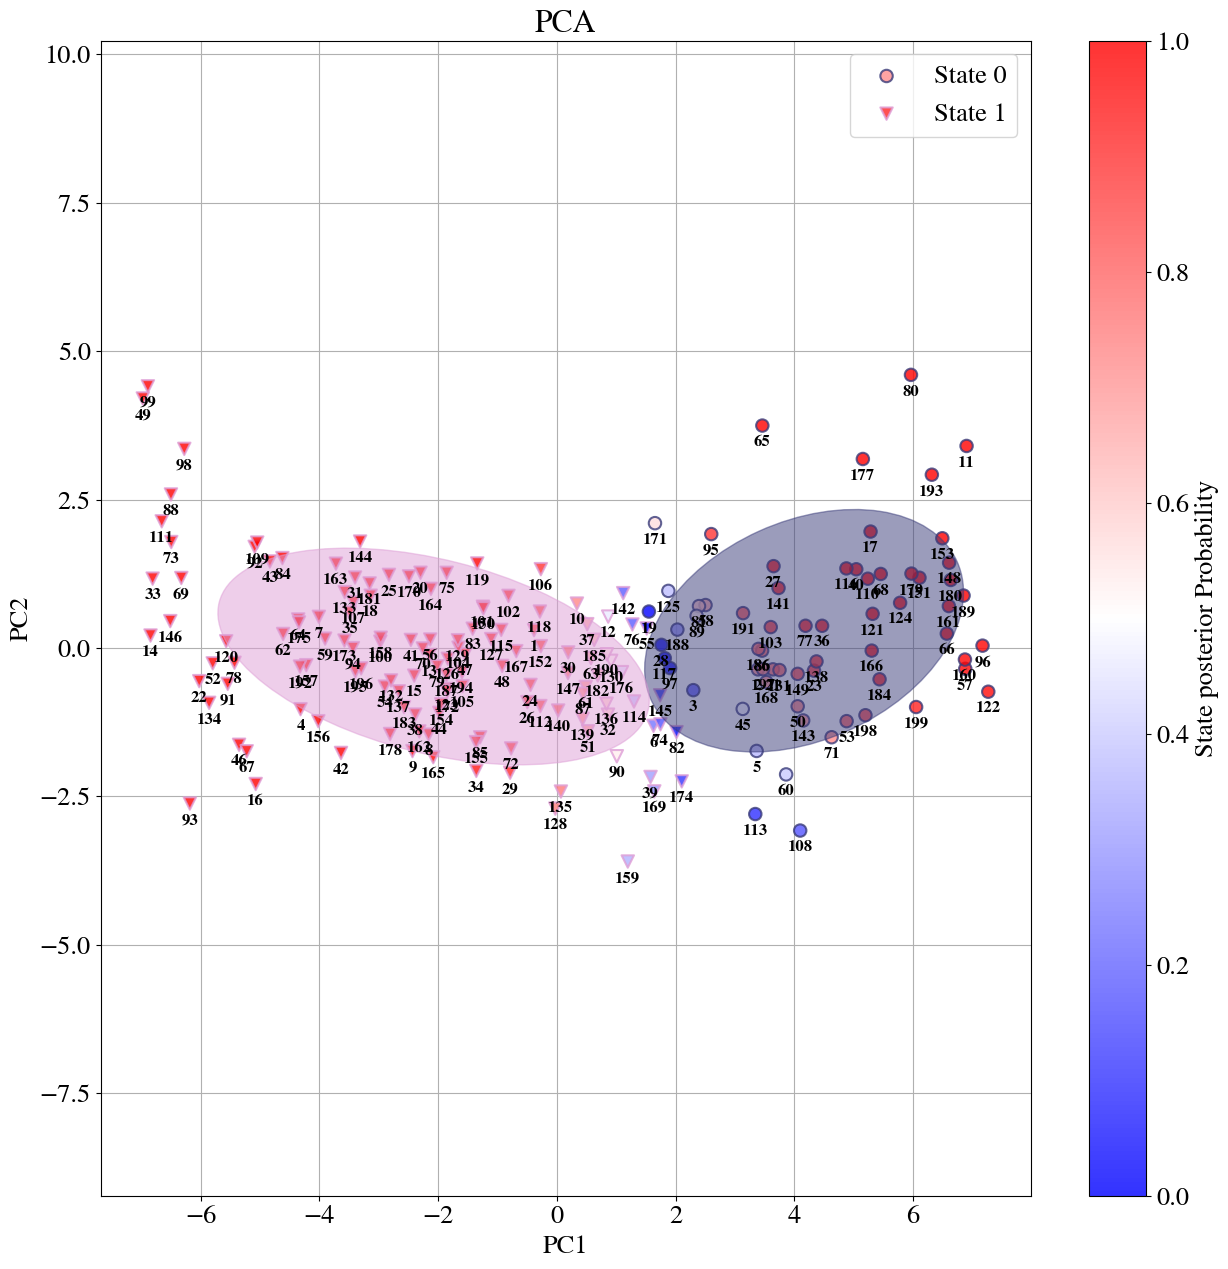

In [9]:
make_ellipses_joint(gmm= example_gmm, X=X,labels=labels, proba=posteriors,cmap="bwr")

To gain insights into the relationship between each cell and its associated state along with their respective posterior probabilities, users can make use of the `posterior_heatmap` feature we have created from `\utils\plotting.py`.
Where each cell can be identified on the x-axis


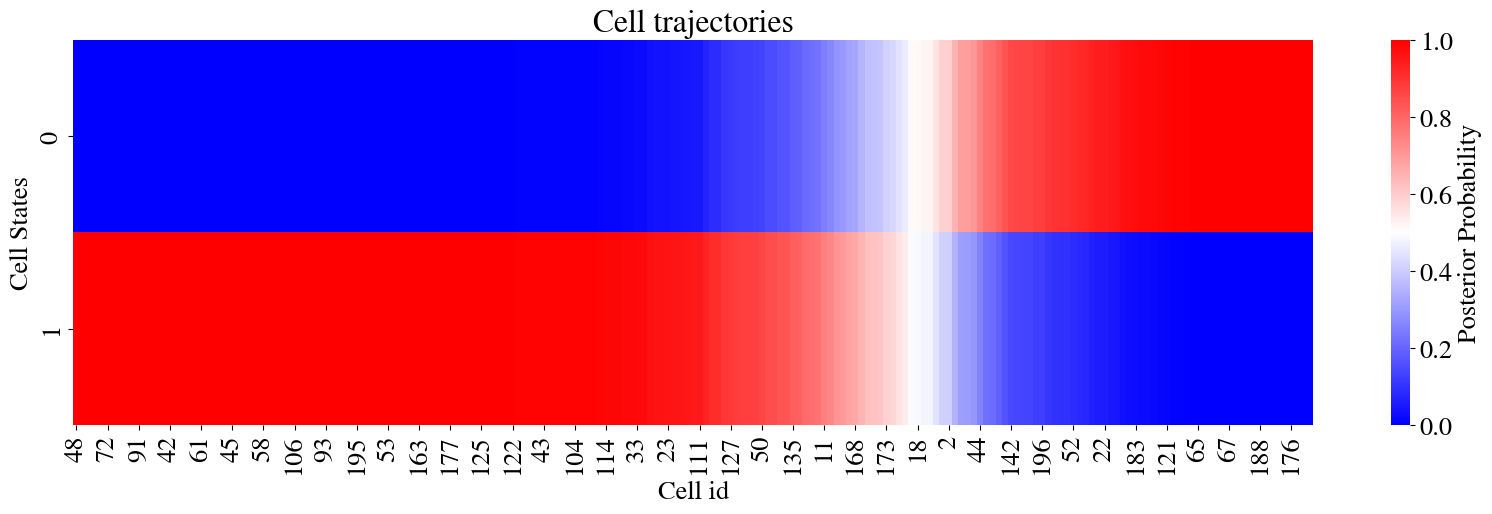

In [10]:
posterior_heatmap(posteriors)

And finally


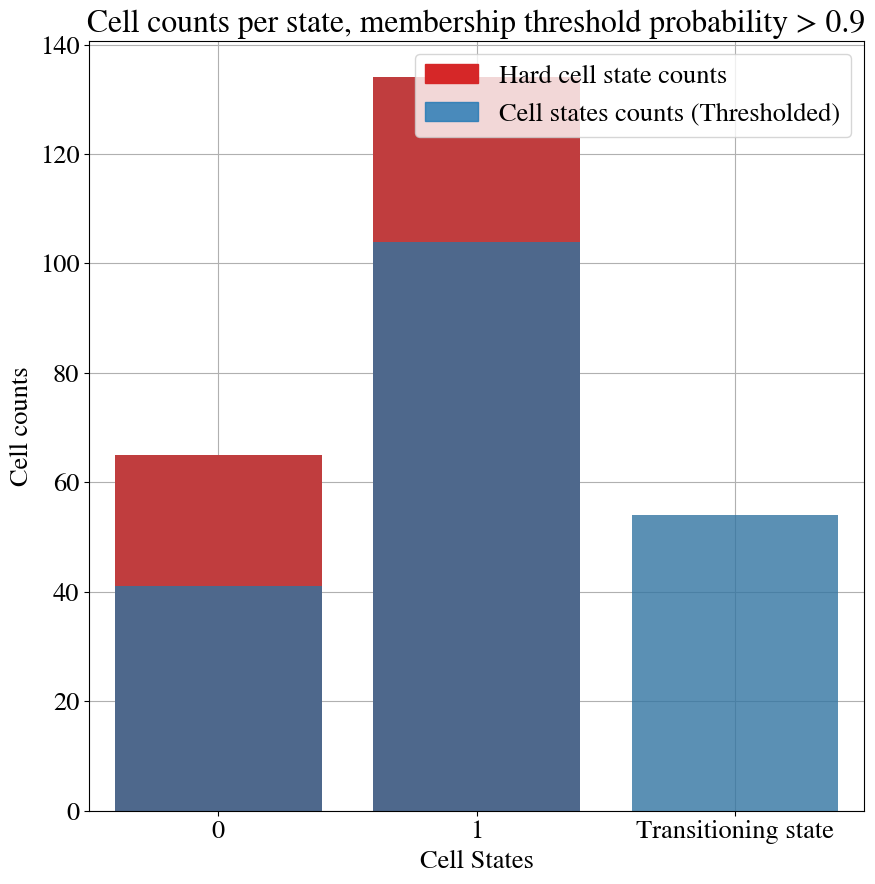

In [11]:
plot_state_cellsums(posteriors,threshold = 0.90,labels=labels)

### _Joint probabilities_


We can obtain the joint distributions via: $$p(\vec{x},c_i) = p(\vec{x}|c_i)p(c_i) = p(\vec{x}|c_i)w_i $$ and summing them together on the axis we can obtain the marginal probability


In [12]:
joint  = posteriors * example_gmm.weights_
joint_sum = joint.sum(axis=1)

No handles with labels found to put in legend.


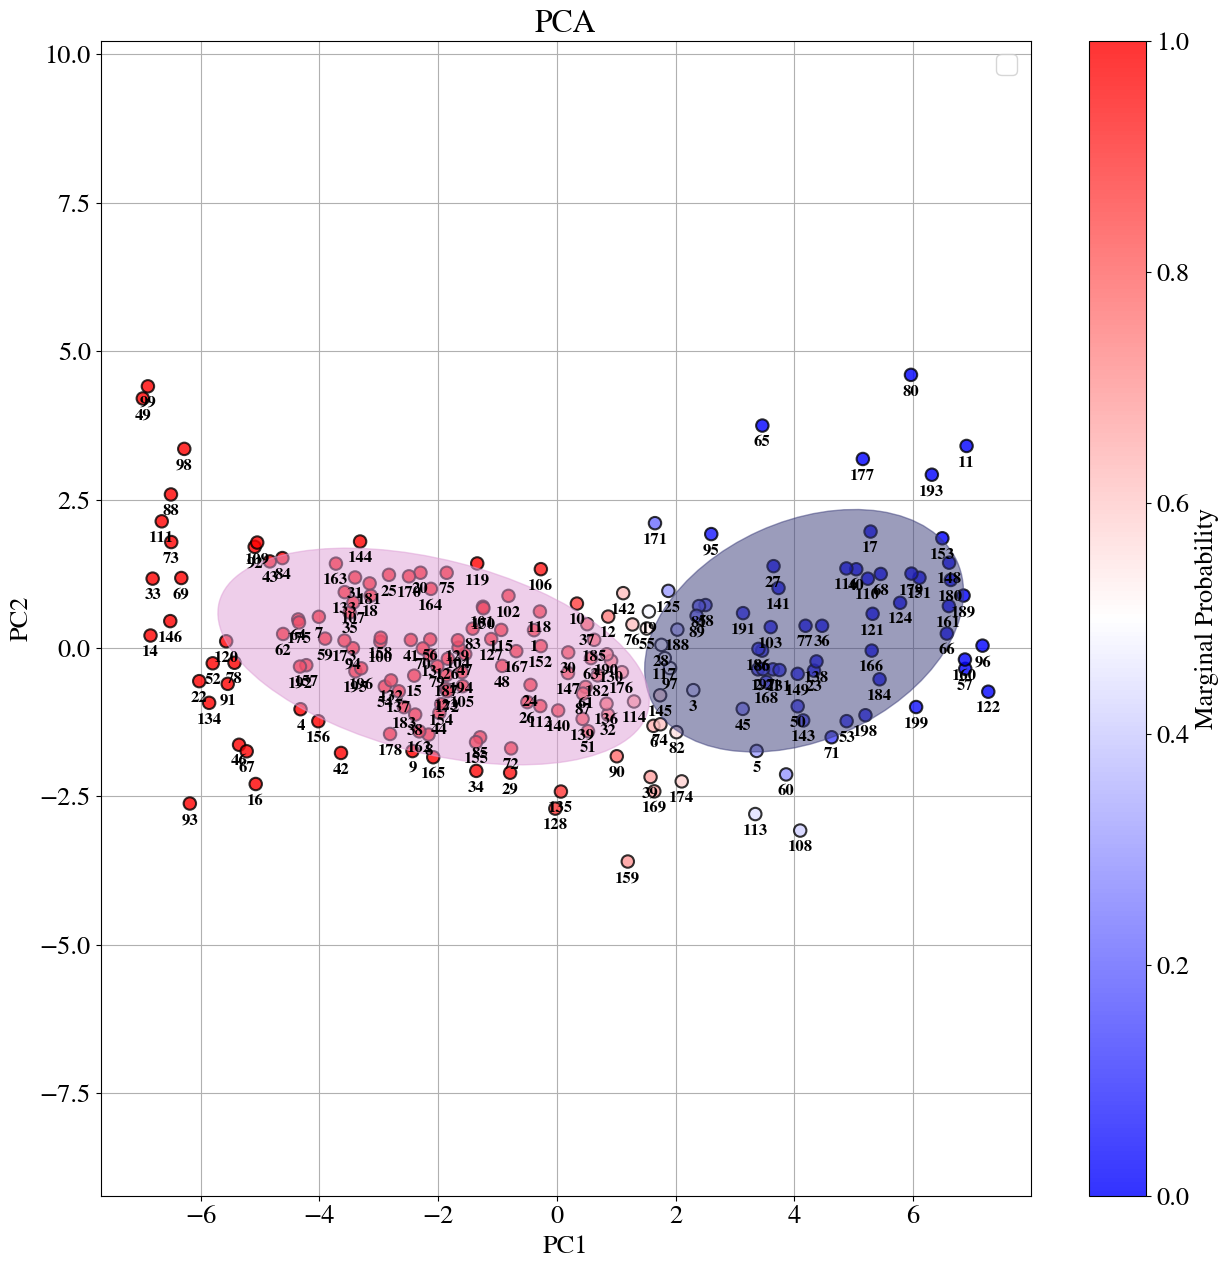

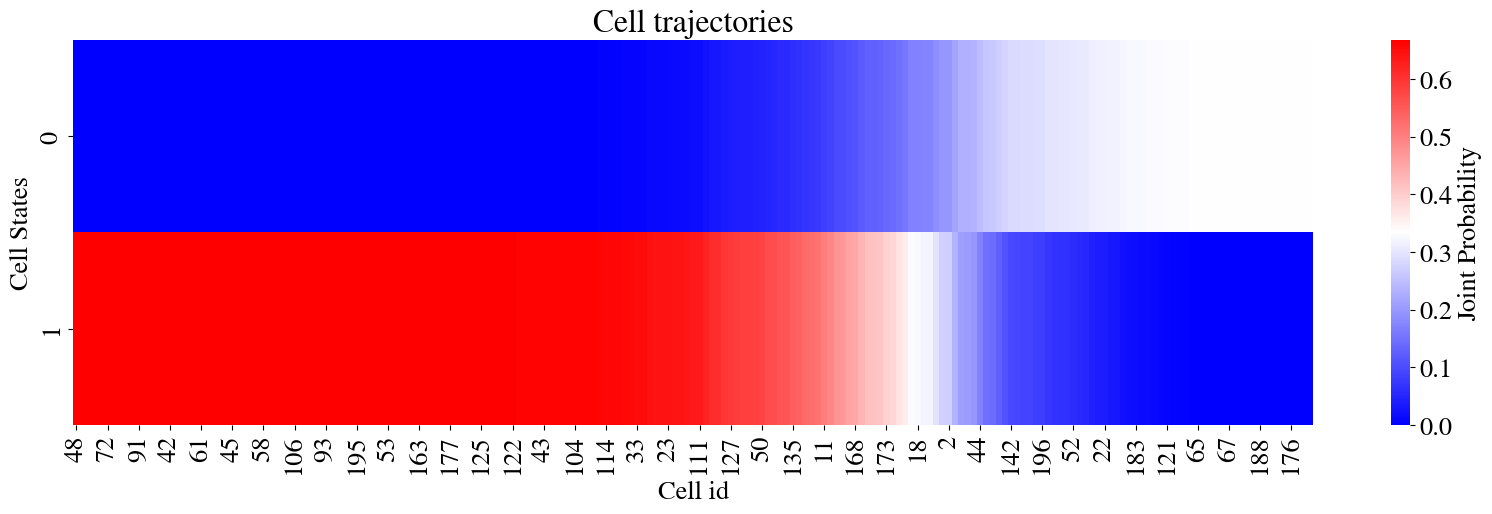

In [13]:
make_ellipses_joint(gmm= example_gmm, X=X,labels=labels, proba=joint_sum,cmap="bwr", joint=True)
posterior_heatmap(joint,c_label='Joint Probability')